<a href="https://colab.research.google.com/github/babisovan/Kaggle-Quora-Question-Pairs/blob/main/Quora_data_preprocess_and_feature_ext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

from fuzzywuzzy import fuzz
import distance
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import Drive API and authenticate
from google.colab import  drive
# Mount your Drive to the Colab VM.
drive.mount('/drive')

main_df = pd.read_csv('/content/drive/MyDrive/Data Science/Quora Question Pairs Kaggle/train.csv')

In [3]:
df = main_df.copy(deep=True)
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id: Looks like a simple rowID
- qid{1, 2}: The unique ID of each question in the pair
- question{1, 2}: The actual textual contents of the questions.
- is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

Observation: Q1 has 1 null value & Q2 has 2 null

In [5]:
df[df['question1'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [6]:
df[df['question2'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


- Found the null values for Q1 & Q2
- Making NaN to space ''

In [7]:
df.fillna('', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
#df.iloc[105780]
df[df['id'] == 105780]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,,0


Distribution of data points among output classes

- check data Balance / Imbalance

is_duplicate
0    255027
1    149263
Name: id, dtype: int64


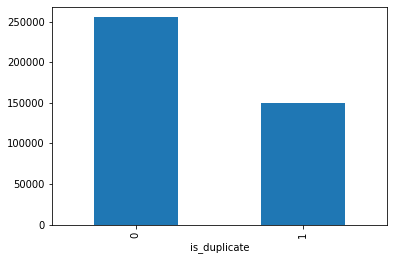

In [9]:
df.groupby('is_duplicate')['id'].count().plot.bar()
print(df.groupby('is_duplicate')['id'].count())

- Number of duplicate(smilar) and non-duplicate(non similar) questions

In [10]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Total number of question pairs for training:
   404290
~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


- Number of unique questions (combined)

In [11]:
df['qid1'].value_counts()>1
df[df['qid1'] == 8461].head(3)
# this is normal, as is_duplicate = 1 is for that reason.
# need to check if combine qid1 + qid2 are present >1 in the dataset or not

,id,qid1,qid2,question1,question2,is_duplicate
4279,4279,8461,8462,How do I improve my English speaking?,How do I improve my pronunciation in English?,1
11300,11300,8461,10859,How do I improve my English speaking?,How can I specifically improve my English?,1
14828,14828,8461,11396,How do I improve my English speaking?,How can I improve my English speaking ability?,1


In [12]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist()) # 404290 + 404290 = 808580 Qs
#print(qids.shape[0])
unique_qs = len(np.unique(qids))
#print(unique_qs)
q_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of total Questions are: {}\n'.format(qids.shape[0]))
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(q_morethan_onetime,q_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))


Total number of total Questions are: 808580

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



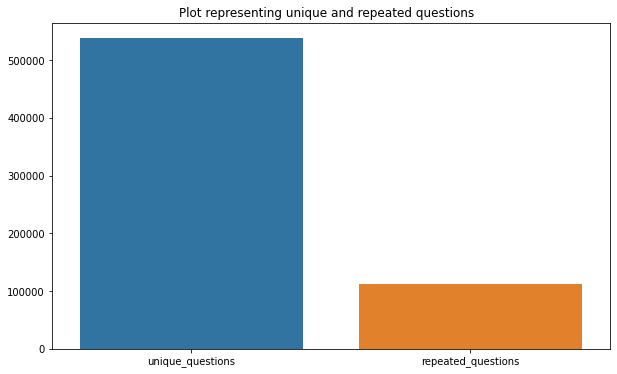

In [13]:
x = ['unique_questions' , 'repeated_questions']
y = [unique_qs , q_morethan_onetime]

plt.figure(figsize = (10,6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

- Checking for Duplicates

In [14]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


- Number of occurrences of each question

[157 120 111 ...   1   1   1]
Maximum number of times a single question is repeated: 157



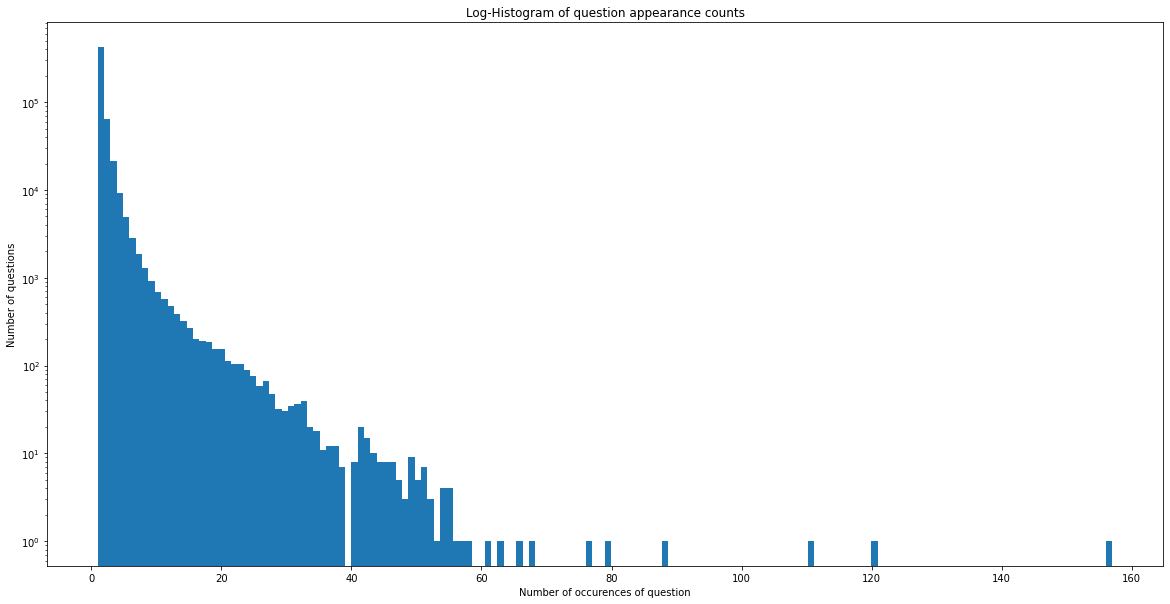

In [15]:
q_vals=qids.value_counts()
#print(q_vals)
q_vals=q_vals.values
print(q_vals)

plt.figure(figsize=(20, 10))

plt.hist(q_vals, bins=160)

plt.yscale('log', nonposy='clip') #log scale to fit high range into scale 
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(q_vals))) 

Text Preprocessing

Preprocessing:
- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [16]:

STOP_WORDS = stopwords.words("english")

def preprocess(x):
  x = str(x).lower()
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
  x = re.sub(r"([0-9]+)000000", r"\1m", x) # 1million
  x = re.sub(r"([0-9]+)000", r"\1k", x) # 1k

  porter = PorterStemmer()

  pattern = re.compile('\W')  #Special charter "$" and "?" are removed from the string.
  if type(x) == type(''):         #returns true if the input type is string. Then you need to perform the operations in the if block.
        x = re.sub(pattern, ' ', x)   #substitute spaces between each word so that we can split on space for tokenisation.

        x = porter.stem(x) #Stemming is performed on the input x 
        example1 = BeautifulSoup(x) #BeautifulSoup() is used to remove html tags.
        x = example1.get_text()

  #https://stackoverflow.com/questions/50888683/meaning-of-re-compiler-w-in-python

  return x

  

In [17]:
#checking func preprocess is working 
print(df['question1'][999])

s = df['question1'].loc[999]
print(preprocess(s))

What is a good song for lyric prank?
what is a good song for lyric prank 


In [18]:
# preprocessing each question and overwrite
df["question1"] = df["question1"].fillna("").apply(preprocess)
df["question2"] = df["question2"].fillna("").apply(preprocess)

- Spell Checking and correction (optional)

In [19]:
'''
#pip install spellchecker
#pip install pyspellchecker
from spellchecker import SpellChecker

spell = SpellChecker()
df['question1'] = df['question1'].apply(spell.correction).replace(abbreviations)
df['question2'] = df['question2'].apply(spell.correction).replace(abbreviations)
'''

"\n#pip install spellchecker\n#pip install pyspellchecker\nfrom spellchecker import SpellChecker\n\nspell = SpellChecker()\ndf['question1'] = df['question1'].apply(spell.correction).replace(abbreviations)\ndf['question2'] = df['question2'].apply(spell.correction).replace(abbreviations)\n"

In [20]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0
...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,0
404286,404286,18840,155606,do you believe there is life after death,is it true that there is life after death,1
404287,404287,537928,537929,what is one coin,what is this coin,0
404288,404288,537930,537931,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,0


Basic Feature Extraction

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [21]:
#df['freq_qid1'] = df.groupby('qid1')
#df['question1'].apply(lambda x : x.split(" "))
#df.groupby('qid1')['qid1'].count() # need to hold df row structure 
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') #https://pbpython.com/pandas_transform.html
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

#set(map(lambda word: word.strip(), df['question1'][0].split(" ")))
def common_word(row):   #(Number of common unique words in Question 1 and Question 2)
  w1 = set(map(lambda word: word.strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.strip(), row['question2'].split(" ")))

  return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(common_word,axis = 1)

def word_Total(row):     #(Total num of words in Question 1 + Total num of words in Question 2)
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(word_Total, axis=1)

def word_share(row):    #(word_common)/(word_Total)
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])



In [22]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,15,13,12.0,25.0,0.480000,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,13,18,8.0,26.0,0.307692,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,15,11,5.0,26.0,0.192308,2,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,13,19,1.0,22.0,0.045455,2,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,16,8,5.0,22.0,0.227273,4,2


Analysis of some of the extracted features
- Here are some questions have only one single words.

In [23]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 50
Number of Questions with minimum length [question2] : 17


- Feature: word_share

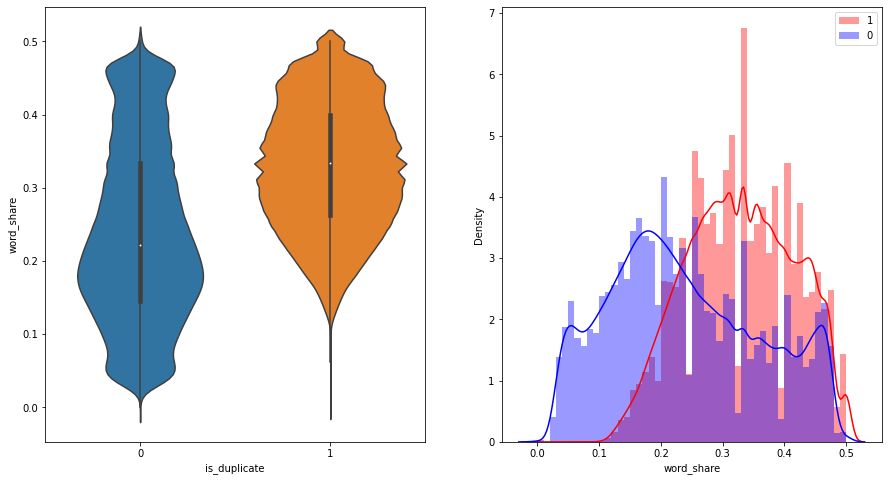

In [24]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data=df[0:])

plt.subplot(1,2,2)
#df[df['is_duplicate'] == 1]['word_share'][0:]
sns.distplot(df[df['is_duplicate'] == 1]['word_share'][0:] , label='1',color='red')
sns.distplot(df[df['is_duplicate'] == 0]['word_share'][0:] , label='0',color='blue')
plt.legend()
plt.show()

Observation:
- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar, i.e. = 1)

<h4> Feature: word_Common </h4>

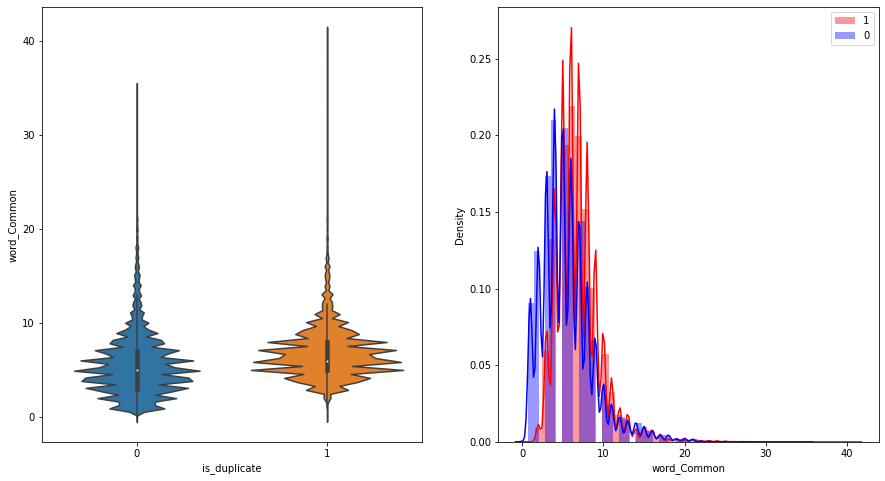

In [25]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

Observation:
<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h4> Feature: word_total </h4>

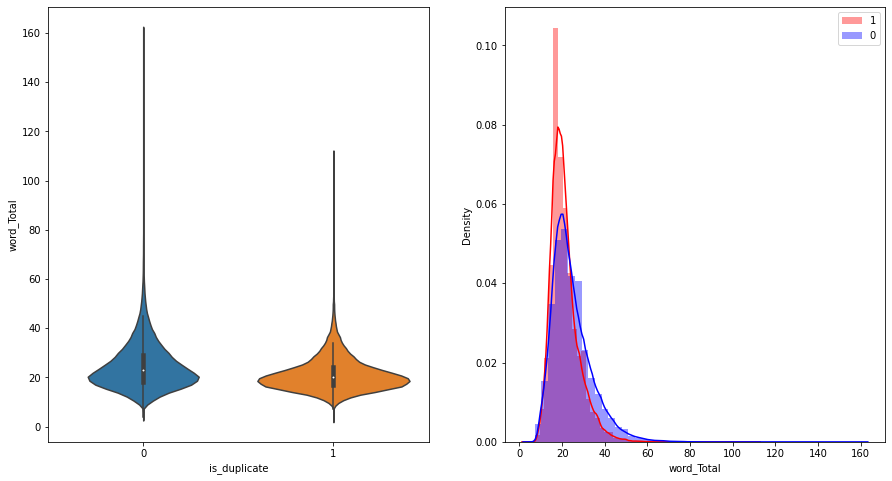

In [26]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Total', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

Observation:
<p> The distributions of the word_Total feature in similar and non-similar questions are highly overlapping </p>

<h2> Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>

- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [27]:
def get_token_features(q1, q2):
    token_features = [0.0]*10    # It is done to create placeholder variable that's ultimately going to store those feature values.
    SAFE_DIV = 0.0001  # to avoid divide by zero error in case the denominator becomes zero.
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    '''here our task is given two questions are they similar or not. so if you look first token it is common_words/ min. 
    so if min length of two questions say is 5 and common_words between them is 5 then 
    this ratio common_words/min becomes 1 so if smallest question length and common_words are equal or 
    close to equal more chance that both questions are similar. Here we are doing feature engineering 
    we try various features like in average token we are trying to capture average length of both the questions 
    if average is high means our question lengths are not small and this feature with others might help to classify 
    if both questions are similar or not.'''
    
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

#distance.lcsubstring will return in a set format. We are converting that to list and getting first position substring length. 
#distance.lcsubstrings function is used to find the longest common substrings in two sequences. 
#If there is no common substring, the function returns 0. 
#get_longest_substr_ratio - It return the ratio of length of common substring and minimum(len(a), len(b)). added +1 to avoid 'div by zero' error

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))    #It returns longest common substring like if a= 'sedentar' and b = 'dentist' then it returns 'dent'.
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)  #in place of len(strs[0]), can use len(strs[n]) where n < len(strs). 



In [28]:
def extract_features(df):
    # preprocessing each question <already done>
    #df["question1"] = df["question1"].fillna("").apply(preprocess)
    #df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [29]:
df = extract_features(df)
#df.to_csv("nlp_features_train.csv", index=False)
#df.to_csv(r'C:\Users\Admin\Desktop\file3.csv', index=False)
df

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,0,2,2,85,79,...,0.785709,1.0,1.0,1.0,13.5,97,88,91,87,0.387500
404286,404286,18840,155606,do you believe there is life after death,is it true that there is life after death,1,12,1,41,42,...,0.555549,1.0,0.0,1.0,8.5,79,69,72,76,0.642857
404287,404287,537928,537929,what is one coin,what is this coin,0,1,1,17,18,...,0.749981,1.0,1.0,0.0,4.0,86,79,79,76,0.444444
404288,404288,537930,537931,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,0,1,1,94,127,...,0.040000,0.0,0.0,8.0,21.0,37,35,30,34,0.052632


In [31]:
# Import Drive API and authenticate
from google.colab import  drive
# Mount your Drive to the Colab VM.
drive.mount('/drive')
#to_csv path & filename
df.to_csv('/drive/My Drive/Data Science/Quora Question Pairs Kaggle/quora_preprocessed_csv.csv')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
